<a href="https://colab.research.google.com/github/haseungchung/Machine-Learning-and-Deep-Learning-Projects/blob/main/Adversarial%20Autoencoder%20(GAN%20%2B%20Autoencoder)%20Network%20for%20Achieving%20Communication%20Signal%20Encryption/Adversarial%20Autoencoder%20(GAN%20%2B%20Autoencoder)%20Network%20for%20Achieving%20Communication%20Signal%20Encryption_Stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# coding: utf-8

# importing libs
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import openpyxl
import sys
import matplotlib
import matplotlib.pyplot as plt
from openpyxl.reader.excel import load_workbook
from numpy.linalg import norm
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras.constraints import max_norm
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD, RMSprop
from keras import backend as K
from keras.models import load_model
from keras.layers.core import Activation
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from google.colab import files

In [2]:
# for reproducing result
from numpy.random import seed
seed(1)
tf.random.set_seed(3)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
M = 4 # number of possible messages
key = 8 # number of bits for key
k = np.log2(M)
k = int(k) # number of bits required to give the message
n_channel = 2
R = k/n_channel
lr=np.array([0.005])
prop=np.array([300])
max_val=1
print ('M:',M,'\nkey:',key)

# Compute the size of the message space, used later in training
m_train = 16
EbNo_train = 10 #10dB

M: 4 
key: 8


In [5]:
def mapping_to_target_range( x, power_min=-np.sqrt(max_val), power_max=np.sqrt(max_val) ) :
    x02 = K.sigmoid(x)*2 # x in range(0,2)
    scale = ( power_max-power_min )/2
    output = x02*scale + power_min
    return output

In [6]:
Txinput0 = Input(shape=(k,)) #message
Txinput1 = Input(shape=(key,)) #key
Txinput = concatenate([Txinput0, Txinput1], axis=1)

Txdense1 = Dense(units=(k + key))(Txinput)
Txdense1a = Activation('relu')(Txdense1)
Txdense2 = Dense(units=(k + key))(Txdense1a)
Txdense2a = Activation('linear')(Txdense2)
Txdense3 = Dense(n_channel, activation=mapping_to_target_range)(Txdense2a)
Txoutput = Txdense3

Tx = Model([Txinput0, Txinput1], Txoutput, name='Tx')
# alice.summary()

In [7]:
'''Addition of AWGN into the output of transmitter to account for channel'''
EbNo_train = 10 #  coverted 7 db of EbNo
cinput = Input(shape=(n_channel,))#message from Alice
coutput = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(cinput)
channel = Model(cinput, coutput, name='channel')
# channel.summary()

In [8]:
Rxinput0 = Input(shape=(n_channel,)) #message
Rxinput1 = Input(shape=(key,)) #key
Rxinput = concatenate([Rxinput0, Rxinput1], axis=1)

Rxdense1 = Dense(units=(n_channel + key))(Rxinput)
Rxdense1a = Activation('relu')(Rxdense1)
Rxdense2 = Dense(units=(n_channel + key))(Rxdense1a)
Rxdense2a = Activation('tanh')(Rxdense2)
Rxoutput =  Dense(k, activation='tanh')(Rxdense2a)

Rx = Model([Rxinput0, Rxinput1], Rxoutput, name='Rx')
# Rx.summary()

In [9]:
einput = Input(shape=(n_channel,)) 

edense1 = Dense(units=(n_channel + key))(einput)
edense1a = Activation('relu')(edense1)
edense2 = Dense(units=(n_channel + key))(edense1a)
edense2a = Activation('tanh')(edense2)
edense3 = Dense(units=(n_channel + key))(edense2a)
edense3a = Activation('tanh')(edense3)
eoutput = Dense(k, activation='tanh')(edense3a)

eve = Model(einput, eoutput, name='eve')

In [10]:
Txout = Tx([Txinput0, Txinput1])
channelout = channel(Txout)
Rxout = Rx([channelout, Rxinput1])# bob sees ciphertext AND key
eveout = eve(channelout)# eve doesn't see the key

In [11]:
eveloss = K.mean(K.sum(K.abs(Txinput0 - eveout), axis=-1))
Rxloss = K.mean(K.sum(K.abs(Txinput0 - Rxout), axis=-1))
TxRxloss = Rxloss + K.square(k/2 - eveloss)/((k/2)**2)*2
TxRxoptim = Adam(lr=0.002)
eveoptim = Adam(lr=0.001) #default 0.001

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
# Build and compile the ABE model, used for training Alice-Bob networks
TxRxmodel = Model([Txinput0, Txinput1, Rxinput1], Rxout, name='TxRxmodel')
TxRxmodel.add_loss(TxRxloss)
TxRxmodel.compile(optimizer=TxRxoptim)

# Build and compile the Eve model, used for training Eve net (with Alice frozen)
Tx.trainable = False
evemodel = Model([Txinput0, Txinput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

In [13]:
TxRxlosses = []
evelosses = []

In [14]:
n_epochs = 700
batch_size = 1024
n_batches = m_train # number of batches
TxRxEvecycles = 1
evecycles = 2

epoch = 0
while epoch < n_epochs:
    TxRxlosses0 = [] #epoch-bound losses for text display during training
    Rxlosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        # Train the TxRx+Eve network
        for cycle in range(TxRxEvecycles):
            # Select a random batch of messages, and a random batch of keys
            m_batch = np.random.randint(0, 2, k * batch_size).reshape(batch_size, k)
            m_batch[m_batch<1] = -1
            k_batch = np.random.randint(0, 2, key * batch_size).reshape(batch_size, key)
            k_batch[k_batch<1] = -1
            TxRxerror = TxRxmodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        TxRxlosses.append(TxRxerror)
        
        # Train the EVE network
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, k * batch_size).reshape(batch_size, k)
            m_batch[m_batch<1] = -1
            k_batch = np.random.randint(0, 2, key * batch_size).reshape(batch_size, key)
            k_batch[k_batch<1] = -1
            Eerror = evemodel.train_on_batch([m_batch, k_batch], None)
            
        evelosses.append(Eerror)

    epoch += 1

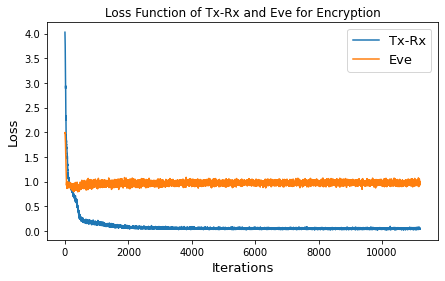

In [15]:
plt.figure(figsize=(7, 4))
plt.plot(TxRxlosses[:], label='Tx-Rx')
plt.plot(evelosses[:], label='Eve')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)
plt.title("Loss Function of Tx-Rx and Eve for Encryption")
plt.show()

In [16]:
n_examples = 10000

m_batch = np.random.randint(0, 2, k * n_examples).reshape(n_examples, k)
k_batch = np.random.randint(0, 2, key * n_examples).reshape(n_examples, key)
m_batch[m_batch<1] = -1
k_batch[k_batch<1] = -1

m_TxRx = np.round(TxRxmodel.predict([m_batch, k_batch, k_batch]))
TxRxdiff = np.abs(m_batch - m_TxRx)
TxRxsum = np.sum(TxRxdiff, axis=-1)
m_eve = np.round(evemodel.predict([m_batch, k_batch]))
evediff = np.abs(m_batch - m_eve)
evesum = np.sum(evediff, axis=-1)

print("TxRx % correct: ", 100.0*np.sum(TxRxsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(evesum == 0) / n_examples, '%')

TxRx % correct:  100.0 %
Eve % correct:  43.3 %
